# Fianl Project

NewBee

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, LogisticGAM, s, f
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV

# lr
from sklearn.linear_model import LogisticRegression

# lda qda
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# rf
from sklearn.ensemble import RandomForestClassifier

# xgboost
import xgboost as xgb

https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_OHXREF.htm      
https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_SMQ.htm#SMD100FL

## Preprocessing - NaN

In [2]:
# oral_health
oral_health = pd.read_sas('P_OHXREF.XPT', format='xport')

In [3]:
oral_health.head()

,SEQN,OHDEXSTS,OHDRCSTS,OHAREC,OHAROCDT,OHAROCGP,OHAROCOH,OHAROCCI,OHAROCDE,OHARNF,OHAROTH,OHAPOS
0,109263.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
1,109264.0,1.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
2,109265.0,1.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
3,109266.0,1.0,1.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
4,109269.0,1.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0


In [4]:
oral_health.drop(columns=['OHDEXSTS','OHDRCSTS','OHAROCDT','OHAROCGP','OHAROCOH','OHAROCCI','OHAROCDE','OHARNF','OHAROTH','OHAPOS'], inplace=True)
oral_health.dropna(subset=['OHAREC'], inplace=True)

In [5]:
oral_health.head()

,SEQN,OHAREC
0,109263.0,3.0
1,109264.0,4.0
2,109265.0,4.0
3,109266.0,3.0
4,109269.0,4.0


In [6]:
oral_health.describe()

,SEQN,OHAREC
count,13276.000000,13276.000000
mean,117092.839937,3.590163
std,4500.752840,0.563355
min,109263.000000,1.000000
25%,113195.500000,3.000000
50%,117125.500000,4.000000
75%,121000.250000,4.000000
max,124821.000000,4.000000


In [7]:
oral_health.shape

(13276, 2)

In [8]:
# smoking
smoking = pd.read_sas('P_SMQ.XPT', format='xport')

In [9]:
smoking.head()

,SEQN,SMQ020,SMD030,SMQ040,SMQ050Q,SMQ050U,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670,SMQ621,SMD630,SMAQUEX2
0,109264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0
1,109266.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,109267.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,109268.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,109271.0,1.0,18.0,1.0,NaN,NaN,NaN,2.0,30.0,20.0,NaN,NaN,1.0,NaN,NaN,1.0


In [10]:
# smoking
smoking = smoking[smoking['SMAQUEX2'] == 1] # choose people older than 18 years old
smoking.drop(columns=['SMQ050Q','SMQ050U','SMQ621','SMD630','SMAQUEX2'], inplace=True)

In [11]:
smoking.head()

,SEQN,SMQ020,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
1,109266.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,109267.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,109268.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,109271.0,1.0,18.0,1.0,NaN,2.0,30.0,20.0,NaN,NaN,1.0
5,109273.0,1.0,18.0,1.0,NaN,1.0,30.0,15.0,1.0,1.0,1.0


In [12]:
smoking.describe()

,SEQN,SMQ020,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
count,9693.000000,9693.000000,3.889000e+03,3889.000000,2205.000000,1273.000000,1.684000e+03,1665.000000,1.592000e+03,1.592000e+03,1684.00000
mean,117075.170329,1.601981,2.292800e+01,2.231165,21.978685,2.628437,2.559501e+01,14.734535,1.011307e+00,5.031407e-01,1.46734
std,4488.053213,0.512981,6.976374e+01,0.921729,82.115711,3.705050,9.649588e+00,62.674692,5.099861e-01,5.836578e-01,0.49908
min,109266.000000,1.000000,5.397605e-79,1.000000,1.000000,1.000000,5.397605e-79,1.000000,5.397605e-79,5.397605e-79,1.00000
25%,113201.000000,1.000000,1.500000e+01,1.000000,5.000000,1.000000,2.500000e+01,4.000000,1.000000e+00,5.397605e-79,1.00000
50%,117037.000000,2.000000,1.700000e+01,3.000000,10.000000,2.000000,3.000000e+01,10.000000,1.000000e+00,5.397605e-79,1.00000
75%,120969.000000,2.000000,2.000000e+01,3.000000,20.000000,3.000000,3.000000e+01,15.000000,1.000000e+00,1.000000e+00,2.00000
max,124822.000000,9.000000,9.990000e+02,3.000000,999.000000,99.000000,9.900000e+01,999.000000,9.000000e+00,9.000000e+00,2.00000


In [13]:
smoking.shape

(9693, 11)

## Preprocessing - merge

In [14]:
data = pd.merge(oral_health, smoking, on='SEQN')
data.head()

,SEQN,OHAREC,SMQ020,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
0,109266.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109271.0,3.0,1.0,18.0,1.0,NaN,2.0,30.0,20.0,NaN,NaN,1.0
2,109273.0,4.0,1.0,18.0,1.0,NaN,1.0,30.0,15.0,1.0,1.0,1.0
3,109274.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,109282.0,4.0,1.0,18.0,3.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
data.shape

(8571, 12)

In [16]:
# corr
data_corr = data[["OHAREC","SMQ020"]]
data_corr = data_corr[data_corr['SMQ020'].isin([1, 2])]
data_corr.head()

,OHAREC,SMQ020
0,3.0,2.0
1,3.0,1.0
2,4.0,1.0
3,3.0,2.0
4,4.0,1.0


In [17]:
data_corr.shape

(8569, 2)

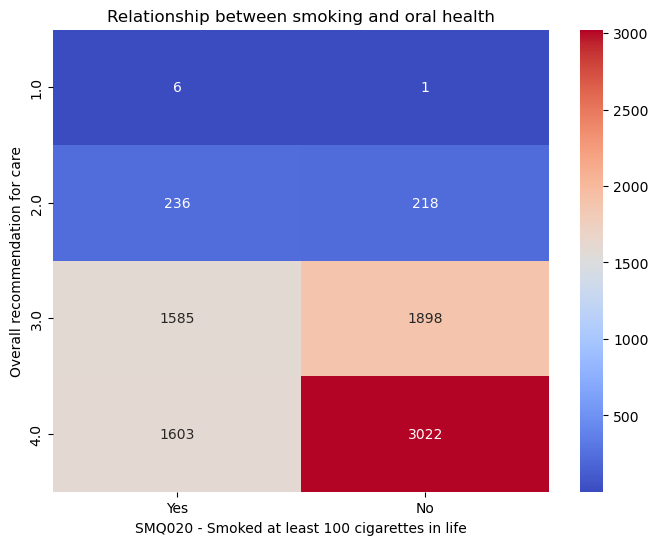

In [18]:
cross_tab = pd.crosstab(data_corr['OHAREC'], data_corr['SMQ020'])

plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='g')
plt.title('Relationship between smoking and oral health')
plt.xticks(ticks=[0.5, 1.5], labels=['Yes', 'No'])
plt.xlabel('SMQ020 - Smoked at least 100 cigarettes in life')
plt.ylabel('Overall recommendation for care')
plt.show()

## Pick the Smoking People

In [19]:
data_sm = data[data['SMQ020'] == 1]
data_sm.head()

,SEQN,OHAREC,SMQ020,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
1,109271.0,3.0,1.0,18.0,1.0,NaN,2.0,30.0,20.0,NaN,NaN,1.0
2,109273.0,4.0,1.0,18.0,1.0,NaN,1.0,30.0,15.0,1.0,1.0,1.0
4,109282.0,4.0,1.0,18.0,3.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
16,109307.0,3.0,1.0,22.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
21,109317.0,3.0,1.0,27.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data_sm.describe()

,SEQN,OHAREC,SMQ020,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
count,3430.000000,3430.000000,3430.0,3.430000e+03,3430.000000,1944.000000,1116.000000,1.486000e+03,1468.000000,1.404000e+03,1.404000e+03,1486.000000
mean,117232.786589,3.395044,1.0,2.298805e+01,2.232070,20.859568,2.574373,2.559556e+01,14.461172,1.014957e+00,5.056980e-01,1.464334
std,4491.104342,0.622256,0.0,7.038887e+01,0.920787,75.156583,3.222793,9.806750e+00,61.513953,5.410359e-01,5.939553e-01,0.498894
min,109271.000000,1.000000,1.0,5.397605e-79,1.000000,1.000000,1.000000,5.397605e-79,1.000000,5.397605e-79,5.397605e-79,1.000000
25%,113306.500000,3.000000,1.0,1.500000e+01,1.000000,5.000000,1.000000,2.500000e+01,4.000000,1.000000e+00,5.397605e-79,1.000000
50%,117314.000000,3.000000,1.0,1.700000e+01,3.000000,10.000000,2.000000,3.000000e+01,10.000000,1.000000e+00,5.397605e-79,1.000000
75%,121183.250000,4.000000,1.0,2.000000e+01,3.000000,20.000000,3.000000,3.000000e+01,15.000000,1.000000e+00,1.000000e+00,2.000000
max,124815.000000,4.000000,1.0,9.990000e+02,3.000000,999.000000,99.000000,9.900000e+01,999.000000,9.000000e+00,9.000000e+00,2.000000


In [21]:
data_sm.shape

(3430, 12)

### more data preprocessing

In [22]:
data_sm_filtered = data_sm[~((data_sm['SMD030'].isin([777, 999])) | 
                            (data_sm['SMD057'].isin([777, 999])) | 
                            (data_sm['SMQ078'].isin([77, 99])) | 
                            (data_sm['SMD641'].isin([77, 99])) | 
                            (data_sm['SMD650'].isin([777, 999])) | 
                            (data_sm['SMD100FL'].isin([7, 9])) | 
                            (data_sm['SMD100MN'].isin([7, 9]))
                            )]

In [23]:
data_sm_filtered.head()

,SEQN,OHAREC,SMQ020,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
1,109271.0,3.0,1.0,18.0,1.0,NaN,2.0,30.0,20.0,NaN,NaN,1.0
2,109273.0,4.0,1.0,18.0,1.0,NaN,1.0,30.0,15.0,1.0,1.0,1.0
4,109282.0,4.0,1.0,18.0,3.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
16,109307.0,3.0,1.0,22.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
21,109317.0,3.0,1.0,27.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_sm_filtered.describe()

,SEQN,OHAREC,SMQ020,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
count,3389.000000,3389.000000,3389.0,3.389000e+03,3389.000000,1924.000000,1108.000000,1.465000e+03,1453.000000,1.385000e+03,1.385000e+03,1465.000000
mean,117248.553556,3.395397,1.0,1.790617e+01,2.231337,15.290021,2.491877,2.536997e+01,10.586373,9.812274e-01,4.916968e-01,1.465529
std,4493.378522,0.622807,0.0,6.365820e+00,0.922408,14.229458,1.430386,8.700444e+00,8.317247,1.357699e-01,5.001116e-01,0.498981
min,109271.000000,1.000000,1.0,5.397605e-79,1.000000,1.000000,1.000000,5.397605e-79,1.000000,5.397605e-79,5.397605e-79,1.000000
25%,113324.000000,3.000000,1.0,1.500000e+01,1.000000,5.000000,1.000000,2.500000e+01,4.000000,1.000000e+00,5.397605e-79,1.000000
50%,117339.000000,3.000000,1.0,1.700000e+01,3.000000,10.000000,2.000000,3.000000e+01,10.000000,1.000000e+00,5.397605e-79,1.000000
75%,121227.000000,4.000000,1.0,2.000000e+01,3.000000,20.000000,3.000000,3.000000e+01,15.000000,1.000000e+00,1.000000e+00,2.000000
max,124815.000000,4.000000,1.0,7.600000e+01,3.000000,95.000000,7.000000,3.000000e+01,95.000000,1.000000e+00,1.000000e+00,2.000000


In [25]:
data_sm_filtered.shape

(3389, 12)

### use mean() to replace NaN

In [26]:
# SMD100MN float error
data_sm_filtered.loc[data_sm_filtered['SMD100MN'] < 0.5, 'SMD100MN'] = 0.0

In [27]:
data_sm_filtered.fillna(round(data_sm_filtered.mean(),0), inplace=True)
data_sm_filtered.head()

/var/folders/rs/36nqgblj1kjdcb97hkj9tgd00000gn/T/ipykernel_34635/676734610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sm_filtered.fillna(round(data_sm_filtered.mean(),0), inplace=True)


,SEQN,OHAREC,SMQ020,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
1,109271.0,3.0,1.0,18.0,1.0,15.0,2.0,30.0,20.0,1.0,0.0,1.0
2,109273.0,4.0,1.0,18.0,1.0,15.0,1.0,30.0,15.0,1.0,1.0,1.0
4,109282.0,4.0,1.0,18.0,3.0,10.0,2.0,25.0,11.0,1.0,0.0,1.0
16,109307.0,3.0,1.0,22.0,3.0,5.0,2.0,25.0,11.0,1.0,0.0,1.0
21,109317.0,3.0,1.0,27.0,3.0,3.0,2.0,25.0,11.0,1.0,0.0,1.0


In [28]:
data_sm_filtered.describe()

,SEQN,OHAREC,SMQ020,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
count,3389.000000,3389.000000,3389.0,3.389000e+03,3389.000000,3389.000000,3389.000000,3.389000e+03,3389.000000,3.389000e+03,3389.000000,3389.000000
mean,117248.553556,3.395397,1.0,1.790617e+01,2.231337,15.164650,2.160814,2.515993e+01,10.822662,9.923281e-01,0.200944,1.201239
std,4493.378522,0.622807,0.0,6.365820e+00,0.922408,10.721247,0.849570,5.722202e+00,5.448764,8.726551e-02,0.400766,0.400986
min,109271.000000,1.000000,1.0,5.397605e-79,1.000000,1.000000,1.000000,5.397605e-79,1.000000,5.397605e-79,0.000000,1.000000
25%,113324.000000,3.000000,1.0,1.500000e+01,1.000000,10.000000,2.000000,2.500000e+01,10.000000,1.000000e+00,0.000000,1.000000
50%,117339.000000,3.000000,1.0,1.700000e+01,3.000000,15.000000,2.000000,2.500000e+01,11.000000,1.000000e+00,0.000000,1.000000
75%,121227.000000,4.000000,1.0,2.000000e+01,3.000000,15.000000,2.000000,3.000000e+01,11.000000,1.000000e+00,0.000000,1.000000
max,124815.000000,4.000000,1.0,7.600000e+01,3.000000,95.000000,7.000000,3.000000e+01,95.000000,1.000000e+00,1.000000,2.000000


In [29]:
X = data_sm_filtered.drop(columns=['OHAREC','SEQN','SMQ020'])
y = data_sm_filtered["OHAREC"]

In [30]:
X.head()

,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
1,18.0,1.0,15.0,2.0,30.0,20.0,1.0,0.0,1.0
2,18.0,1.0,15.0,1.0,30.0,15.0,1.0,1.0,1.0
4,18.0,3.0,10.0,2.0,25.0,11.0,1.0,0.0,1.0
16,22.0,3.0,5.0,2.0,25.0,11.0,1.0,0.0,1.0
21,27.0,3.0,3.0,2.0,25.0,11.0,1.0,0.0,1.0


In [31]:
y.head()

1     3.0
2     4.0
4     4.0
16    3.0
21    3.0
Name: OHAREC, dtype: float64

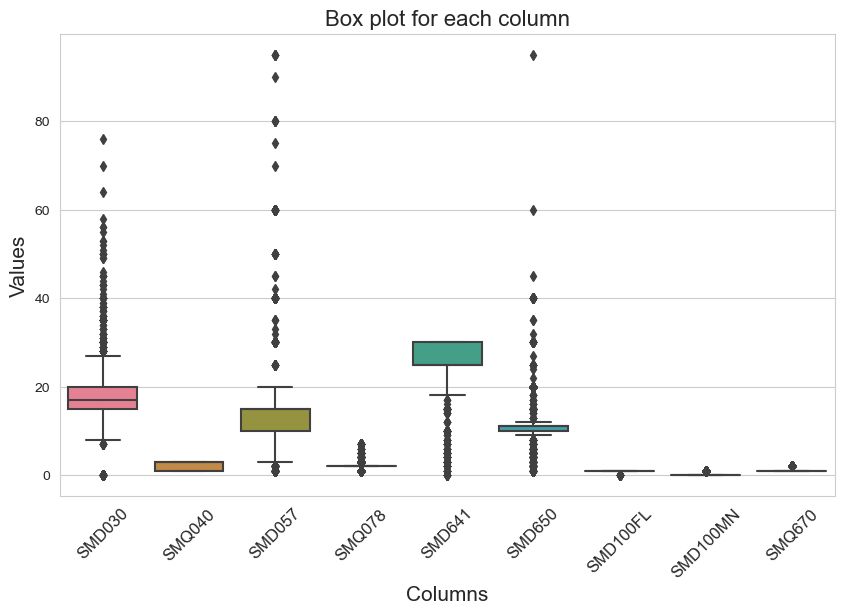

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=X, palette="husl")
plt.title('Box plot for each column', fontsize=16)
plt.ylabel('Values', fontsize=15)
plt.xlabel('Columns', fontsize=15)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
plt.show()

### collinearity / SMD100MN

In [33]:
X.corr()

,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
SMD030,1.000000,-0.023496,-0.042558,0.072539,-0.023305,-0.129041,0.002954,0.063852,-0.038506
SMQ040,-0.023496,1.000000,0.012801,-0.252760,-0.284489,-0.083977,0.088058,-0.538581,-0.603108
SMD057,-0.042558,0.012801,1.000000,-0.002908,-0.000429,0.000500,0.001351,-0.007702,-0.007710
SMQ078,0.072539,-0.252760,-0.002908,1.000000,0.091791,-0.252901,-0.035110,0.117452,0.060064
SMD641,-0.023305,-0.284489,-0.000429,0.091791,1.000000,0.372579,0.043834,-0.003979,0.195261
SMD650,-0.129041,-0.083977,0.000500,-0.252901,0.372579,1.000000,0.003966,-0.157230,0.160077
SMD100FL,0.002954,0.088058,0.001351,-0.035110,0.043834,0.003966,1.000000,-0.048743,-0.023346
SMD100MN,0.063852,-0.538581,-0.007702,0.117452,-0.003979,-0.157230,-0.048743,1.000000,0.253383
SMQ670,-0.038506,-0.603108,-0.007710,0.060064,0.195261,0.160077,-0.023346,0.253383,1.000000


In [34]:
X["SMD100MN"].unique()

array([0., 1.])

###  data imbalance

In [99]:
from collections import Counter
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
print("Random Oversampling:")
print(sorted(Counter(y_ros).items()))

Random Oversampling:
[(1.0, 1586), (2.0, 1586), (3.0, 1586), (4.0, 1586)]


In [100]:
X_ros.describe()

,SMD030,SMQ040,SMD057,SMQ078,SMD641,SMD650,SMD100FL,SMD100MN,SMQ670
count,6.344000e+03,6344.000000,6344.000000,6344.000000,6.344000e+03,6344.000000,6.344000e+03,6344.000000,6344.000000
mean,1.787153e+01,2.302018,14.533575,2.128941,2.466078e+01,10.913304,9.959016e-01,0.211066,1.172762
std,6.295727e+00,0.892039,9.663932,0.758007,5.969944e+00,5.022232,6.389216e-02,0.408097,0.378071
min,5.397605e-79,1.000000,1.000000,1.000000,5.397605e-79,1.000000,5.397605e-79,0.000000,1.000000
25%,1.400000e+01,1.000000,10.000000,2.000000,2.500000e+01,10.000000,1.000000e+00,0.000000,1.000000
50%,1.700000e+01,3.000000,15.000000,2.000000,2.500000e+01,11.000000,1.000000e+00,0.000000,1.000000
75%,2.100000e+01,3.000000,15.000000,2.000000,3.000000e+01,11.000000,1.000000e+00,0.000000,1.000000
max,7.600000e+01,3.000000,95.000000,7.000000,3.000000e+01,95.000000,1.000000e+00,1.000000,2.000000


In [101]:
X = X_ros
y = y_ros

## GAM

https://github.com/dswah/pyGAM/pull/213

In [74]:
gam = LogisticGAM(f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8), n_splines=5)
ensemble = OneVsRestClassifier(gam, n_jobs=1)
ensemble.fit(X, y)

OneVsRestClassifier(estimator=LogisticGAM(callbacks=['deviance', 'diffs', 'accuracy'], 
   fit_intercept=True, max_iter=100, n_splines=5, 
   terms=f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8),
   tol=0.0001, verbose=False),
                    n_jobs=1)

In [75]:
ensemble.predict_proba(X)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
gam.summary()

In [ ]:
lams = [np.array([0.5, 1, 5, 10])] * 3
gam.gridsearch(X, y, lam=lams)

In [ ]:
gam.lam

## Linear Regression lasso/ridge

### Preprocessing - onehotcoder

In [102]:
X_need_encode = X[["SMQ040", "SMD100FL", "SMD100MN", "SMQ670"]]
encoder = OneHotEncoder()
X_need_encoded = encoder.fit_transform(X_need_encode)

In [103]:
X_need_encoded_pro = pd.DataFrame(X_need_encoded.toarray())
X_need_encoded_pro.index = X.index
stt = []
for i in X_need_encoded_pro.columns:
    stt.append(str(i))
X_need_encoded_pro.columns = stt
X_need_encoded_pro.head()

,0,1,2,3,4,5,6,7,8
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [104]:
X_left = X.drop(["SMQ040", "SMD100FL", "SMD100MN", "SMQ670"], axis=1)
X_encoded = pd.concat([X_need_encoded_pro, X_left], axis=1)
X_encoded.head()

,0,1,2,3,4,5,6,7,8,SMD030,SMD057,SMQ078,SMD641,SMD650
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,18.0,15.0,2.0,30.0,20.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,18.0,15.0,1.0,30.0,15.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,18.0,10.0,2.0,25.0,11.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,22.0,5.0,2.0,25.0,11.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,27.0,3.0,2.0,25.0,11.0


In [105]:
X_encoded.columns = ['SMQ040_1', 'SMQ040_2', 'SMQ040_3', 'SMD100FL_0', 'SMD100FL_1', 'SMD100MN_0', 'SMD100MN_1',
                     'SMQ670_1', 'SMQ670_2', 'SMD030', 'SMD057', "SMQ078", 'SMD641', 'SMD650']
X_encoded.head()

,SMQ040_1,SMQ040_2,SMQ040_3,SMD100FL_0,SMD100FL_1,SMD100MN_0,SMD100MN_1,SMQ670_1,SMQ670_2,SMD030,SMD057,SMQ078,SMD641,SMD650
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,18.0,15.0,2.0,30.0,20.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,18.0,15.0,1.0,30.0,15.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,18.0,10.0,2.0,25.0,11.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,22.0,5.0,2.0,25.0,11.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,27.0,3.0,2.0,25.0,11.0


In [106]:
X_encoded.shape

(6344, 14)

### Cross-Validation

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [108]:
X_train.head()

,SMQ040_1,SMQ040_2,SMQ040_3,SMD100FL_0,SMD100FL_1,SMD100MN_0,SMD100MN_1,SMQ670_1,SMQ670_2,SMD030,SMD057,SMQ078,SMD641,SMD650
1699,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,23.0,15.0,2.0,15.0,2.0
57,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,15.0,3.0,2.0,25.0,11.0
3641,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,15.0,20.0,2.0,25.0,11.0
3039,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,20.0,15.0,2.0,30.0,5.0
6301,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,22.0,6.0,2.0,25.0,11.0


### Logistic + ridge

In [114]:
rdg = LogisticRegression(penalty='l2', multi_class='multinomial', C=0.01, max_iter = 5000)
rdg.fit(X_encoded, y)

LogisticRegression(C=0.01, max_iter=5000, multi_class='multinomial')

In [115]:
rdg.score(X_encoded, y)

0.462484237074401

In [116]:
y_pred = rdg.predict(X_encoded)
(y_pred != y).mean()

0.537515762925599

In [117]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
1 - np.mean(cross_val_score(rdg, X_encoded, y, cv=cv, scoring='accuracy'))

0.5540652740800402

In [130]:
rdg.coef_

array([[-7.86155709e-01,  4.65344957e-02,  7.41106956e-01,
        -4.43736095e-02,  4.58593525e-02, -2.20160947e-01,
         2.21646690e-01,  4.44082617e-01, -4.42596874e-01,
        -2.74821856e-02, -2.07893103e-02, -9.80072308e-02,
        -7.11660636e-02,  6.75261403e-02],
       [ 4.91375947e-01, -2.94507008e-02, -4.57963684e-01,
        -7.38721402e-02,  7.78337027e-02,  3.45676073e-02,
        -3.06060448e-02, -1.88702218e-01,  1.92663780e-01,
         1.83026495e-02,  9.06019019e-03, -7.23013220e-04,
         2.78701813e-02, -1.52061824e-02],
       [ 2.91913797e-01,  3.50622737e-03, -3.00192948e-01,
         5.70518723e-02, -6.18247960e-02, -1.05301385e-02,
         5.75721484e-03, -1.55654980e-01,  1.50882057e-01,
         1.82295911e-03,  4.84492258e-03,  5.20755651e-03,
         2.69869700e-02, -2.13457876e-02],
       [ 2.86596452e-03, -2.05900222e-02,  1.70496757e-02,
         6.11938773e-02, -6.18682593e-02,  1.96123478e-01,
        -1.96797860e-01, -9.97254190e-02,  9.

In [131]:
rdg.intercept_

array([ 1.27287835, -0.7566218 , -0.15429632, -0.36196024])

In [113]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

logreg = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='multinomial', max_iter=5000)
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_encoded, y)

grid_search.best_params_['C']

0.01

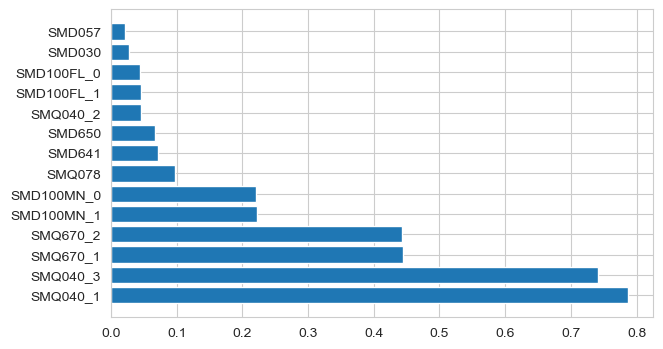

In [132]:
importance = np.abs(rdg.coef_[0])

sorted_indices = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_indices]
sorted_features = X_encoded.columns[sorted_indices]

plt.figure(figsize=(7, 4))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.show()

### Logistic + lasso

In [58]:
lasso = LogisticRegression(penalty='l1', solver = 'saga', multi_class='multinomial', max_iter = 5000)
lasso.fit(X_encoded, y)

LogisticRegression(max_iter=5000, multi_class='multinomial', penalty='l1',
                   solver='saga')

In [59]:
lasso.score(X_encoded, y)

0.4219735182849937

In [60]:
y_pred = lasso.predict(X_encoded)
(y_pred != y).mean()

0.5780264817150063

## Random Forest

In [168]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15)
rf.fit(X_encoded, y)

RandomForestClassifier(max_depth=15, random_state=42)

In [169]:
y_pred = rf.predict(X_encoded)
(y_pred != y).mean()

0.1908890290037831

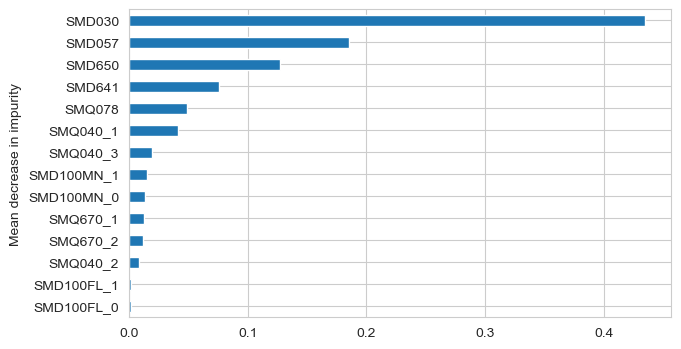

In [177]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index= rf.feature_names_in_)
plt.figure(figsize=(7,4))
forest_importances.sort_values(ascending = True).plot.barh()
plt.ylabel("Mean decrease in impurity")
plt.show()

In [170]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
1 - np.mean(cross_val_score(rf, X_encoded, y, cv=cv, scoring='accuracy'))

0.30800724880864494

## XGBoost

In [171]:
yy_train = y_train-1
yy_test = y_test-1

In [174]:
dtrain = xgb.DMatrix(X_train, label=yy_train)
dtest = xgb.DMatrix(X_test, label=yy_test)

In [204]:
import xgboost as xgb
params = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'max_depth': 22,
    'eta': 0.3,
    'eval_metric': 'merror'
}

num_rounds = 1000
xgb = xgb.train(params, dtrain, num_rounds)

In [205]:
y_pred = xgb.predict(dtest)
(y_pred != yy_test).mean()

0.32466509062253746

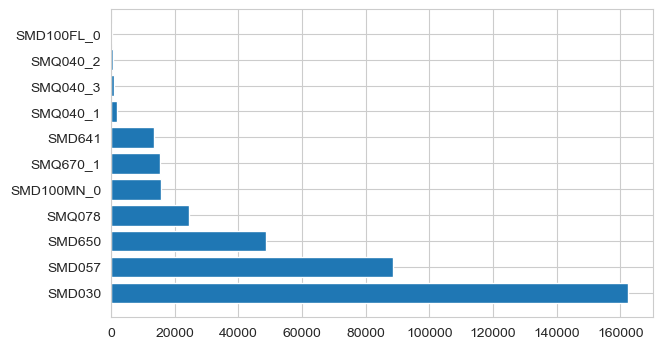

In [206]:
importance = xgb.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

features = [x[0] for x in sorted_importance]
importance_values = [x[1] for x in sorted_importance]

plt.figure(figsize=(7, 4))
plt.barh(range(len(importance_values)), importance_values, align='center')
plt.yticks(range(len(importance_values)), features)
plt.show()